# Creating an Airport Based Feature Vector

In this notebook, we will build upon the understanding gathered during the data analysis and create a feature vector that is supposed to be fed into a learning algorithm.

In [1]:
import os.path
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import pandas as pd
import json
import requests
from IPython.display import clear_output
import cesiumpy
import random
from geomet import wkt
from pandas.io.json import json_normalize, read_json
from SPARQLWrapper import SPARQLWrapper, JSON, XML, RDF
from datetime import datetime
from IPython.display import HTML

#Set some parameters for nicer visualizations
pd.set_option('display.expand_frame_repr', False) #do not wrap the printout of Pandas DataFrames
pd.set_option('display.precision', 2)
pd.set_option('display.max_columns', 50)
mp.rcParams['figure.figsize'] = (15, 9)
mp.pyplot.style.use = False
%matplotlib inline

# initialize my connection module which allows to connect oto both datAcron graph databases
from datacron_connector import TripleStoreConnector
ts107 = TripleStoreConnector(0)
ts109 = TripleStoreConnector(1)

In [2]:
level3airports = 'data/level3airports.csv'
if not os.path.isfile(level3airports):
    qry = """
    PREFIX : <http://www.datacron-project.eu/datAcron#>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX dul: <http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#>
    PREFIX myfn: <java:datAcronTester.unipi.gr.sparql_functions.>

    SELECT ?s ?icao ?iata ?wkt 
    WHERE{
        VALUES ?icao { 'LEMD' 'LEBL' 'LEPA' 'LEBB' 'LEAL' 'LEMG' 'LEVC'}
        ?s :hasICAOcode ?icao;
           :hasIATAcode ?iata;
           :hasGeometry/:hasMBR_WKT ?wkt.
    }
    """
    dfad = ts107.query(qry)
    dfad = ts107.clean(dfad)
    dfad['geojson'] = dfad['wkt'].apply(lambda x: wkt.loads(x))
    dfad['sta'] = '2016-04-01T00:00'
    dfad['end'] = '2016-04-30T23:59:59'
    dfad['sta'] = pd.to_datetime(dfad['sta'])
    dfad['end'] = pd.to_datetime(dfad['end'])
    dfad['duration'] = dfad['end'] - dfad['sta']
    dfad.to_csv(level3airports)
else:
    dfad = pd.read_csv(level3airports, index_col=0)
    import ast
    dfad['geojson'] = dfad['geojson'].map(ast.literal_eval) #convert string to dict
    dfad['sta'] = pd.to_datetime(dfad['sta'])
    dfad['end'] = pd.to_datetime(dfad['end'])
    dfad['duration'] = pd.to_timedelta(dfad['duration'])
    
dfad.set_index('icao', inplace=True)   

In [3]:
#rwys = pd.Series([280, 250, 240, 180, 320, 190, 240, 300], index = [0, 1, 2, 3, 4, 5, 6])
rwys = pd.Series({'LEAL': 280, 'LEBB': 300, 'LEBL': 250, 'LEMD': 180, 'LEMG': 320, 'LEPA': 240, 'LEVC': 300 })
rwys = pd.DataFrame(rwys)
rwys = rwys.rename(columns={0: 'rwys'})
dfad = pd.merge(dfad, rwys, left_index=True, right_index=True)

## Slicing into 1 hour timeframes

Now we have the basic airport listings for the major spanish level 3 airports and two additionaly columns representing a validity for the AIRAC cycles 411 and 412. As in the notebook 5.1, the following procedure will generate a (huge) DataFrame, derivec from `dfad` by slicing the rows into mulitple rows, each containing the airport reference, but a validity of max. 1 hour.

In [4]:
mytimedelta = pd.Timedelta('1 hour')

#Create a boolean mask with rows to split (a vector of (True, True, False, ...) of length len(df))
split_rows = (dfad['duration'] > mytimedelta)    
i = 1

while split_rows.any():
    #get new rows to append and adjust start time to 1 hour later.
    new_rows = dfad[split_rows].copy()
    new_rows['sta'] = new_rows['sta'] + mytimedelta

    #update the end time of old rows
    dfad.loc[split_rows, 'end'] = dfad.loc[split_rows, 'sta'] + \
        pd.DateOffset(hours=1, seconds=-1)
    dfad = dfad.append(new_rows)
    
    #update the duration of all rows
    dfad['duration'] = dfad['end'] - dfad['sta']
    
    #create an updated boolean mask
    split_rows = (dfad['duration'] > mytimedelta)
    
    #give info to user
    clear_output(wait=True)
    i = i + 1
    print('Iteration' + str(i) + ' done.')

# reset index and make icao code a normal column again
dfad = dfad.reset_index(drop=False)
dfad = dfad.rename(columns={'index': 'icao'})
    

Iteration720 done.


# Enriching the dataset with weather information

As we now have the airport and some time sliced data, we can now enrich the dataset by inserting weather, capacity and demand information. We will start off with the weather information, taken from the `darksky.net` API. 

In [5]:
dfwx = dfad.copy()
failed_requests = {}

dfwx['wx'] = ""
for index, row in dfwx.iterrows():
    airport = row['s']
    tim = row['sta'].strftime('%Y-%m-%dT%H:%M:%S') +'Z'
    lon = format(row['geojson']['coordinates'][0], '.2f')
    lat = format(row['geojson']['coordinates'][1], '.2f')
    qry = "https://api.darksky.net/forecast/5456d39a8263a71b4a425f871205fc67/"
    qry = qry + "{la},{lo},{ti}?exclude=hourly,daily&units=si".format(la = str(lat), lo = str(lon), ti = tim)
    try:
        ret = requests.get(qry)
        clear_output(wait=True)
        print('iteration ' + str(index) + ' done: response 200 is good:' )
        print(ret)
        dfwx.at[index, 'wx'] = ret.json()
    except:
        failed_requests[index] = qry
        print('iteration ' + str(index) + ' failed: adding to failed request dict' )
        pass


iteration 5039 done: response 200 is good:
<Response [200]>


For all requests that failed due to timeouts, we will simply repeat the process until we are done:

In [6]:
dfmissingwx = dfwx[dfwx['wx'].str.len() < 5]
for index, row in dfmissingwx.iterrows():
    airport = row['s']
    tim = row['sta'].strftime('%Y-%m-%dT%H:%M:%S') +'Z'
    lon = format(row['geojson']['coordinates'][0], '.2f')
    lat = format(row['geojson']['coordinates'][1], '.2f')
    qry = "https://api.darksky.net/forecast/5456d39a8263a71b4a425f871205fc67/"
    qry = qry + "{la},{lo},{ti}?exclude=hourly,daily&units=si".format(la = str(lat), lo = str(lon), ti = tim)
    try:
        ret = requests.get(qry)
        clear_output(wait=True)
        print('iteration ' + str(index) + ' done: response 200 is good:' )
        print(ret)
        dfwx.at[index, 'wx'] = ret.json()
    except:
        failed_requests[index] = qry
        print('iteration ' + str(index) + ' failed: adding to failed request dict' )
        pass

In [7]:
i = 0 
for index, qry in list(failed_requests.items()):
    print(len(failed_requests))
    try:
        ret = requests.get(qry)
        clear_output(wait=True)
        print('iteration ' + str(index) + ' done')
        dfwx.at[index, 'wx'] = ret.json()
        del failed_requests[index]
    except:
        i = i+1
        pass
    if i > 1000:
        break


Now we are going to place the received wx JSON data into individual columns for our feature vector. First, we create the columns with standard values according to the ISA standard atmosphere: https://en.wikipedia.org/wiki/International_Standard_Atmosphere. Second, we extract the wx column into a temporary dataFrame of the same length, and overwrite the ISA standard information with the information given in that DataFrame. Values not available in the JSAON are being taken care of by the `json_normalize` function and converted to NaN.

In [8]:
dftemp = pd.io.json.json_normalize(dfwx['wx'])

In [9]:
dfwx['humidity'] = 0.0
dfwx['dewPoint'] = -15.0
dfwx['temperature'] = 15.0
dfwx['pressure'] = 1013.25
dfwx['visibility'] = 10.0
dfwx['windBearing'] = 0
dfwx['windSpeed'] = 0.0
dfwx['windGust'] = 0.0
dfwx['precipIntensity'] = 0.0
dfwx['precipProbability'] = 0.0
dfwx['storm'] = 0
dfwx['humidity'] = dftemp['currently.humidity']
dfwx['dewPoint'] = dftemp['currently.dewPoint']
dfwx['temperature'] = dftemp['currently.temperature']
dfwx['pressure'] = dftemp['currently.pressure']
dfwx['visibility'] = dftemp['currently.visibility']
dfwx['windBearing'] = dftemp['currently.windBearing']
dfwx['windSpeed'] = dftemp['currently.windSpeed']
dfwx['precipIntensity'] = dftemp['currently.precipIntensity']
dfwx['precipProbability'] = dftemp['currently.precipProbability']

#dfwx['storm'] = dftemp['currently.nearestStormDistance']
#dfwx['windGust'] = dftemp['currently.windGust']

# Enriching the dataset with datAcron weather

Additionally, we want to pull the requested variables from the datAcron weather source, which was made available in the last weeks of the project:

In [11]:
dfwx['datacron_wx'] = ''

for index, row in dfwx.iterrows():
    tim = row['sta'].strftime('%Y-%m-%dT%H:%M:%S')
    lon = format(row['geojson']['coordinates'][0], '.2f')
    lat = format(row['geojson']['coordinates'][1], '.2f')
    qry = """
        PREFIX dul: <http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#>
        PREFIX : <http://www.datacron-project.eu/datAcron#>
        PREFIX myfn: <java:datAcronTester.unipi.gr.sparql_functions.>

        SELECT (myfn:getWeather("""+ lon + """, """ + lat + """, 0, '""" + tim + """') as ?w) 
        WHERE{ }    
    """

    wx = ts109.query(qry)
    wx = ts107.clean(wx)
    dfwx.at[index, 'datacron_wx'] = wx.loc[0, 'w'] 
    clear_output(wait=True)
    print('Iteration' + str(index) + ' of ' + str(len(dfwx)) + ' done.')

Iteration5039 of 5040 done.


In [12]:
#dftemp = dfwx.head(5).copy()
dftemp = dfwx['datacron_wx'].str.split('|', expand=True)
#dftemp['dat.cape'] = dftemp['split'][0]
#pd.set_option('display.max_colwidth', 60)

dftemp = dftemp.rename(columns={0:'dat.cape', 1: 'dat.tempk', 2: 'dat.press', 3:'dat.humi', 4:'dat.precip'})
dftemp = dftemp.drop([5, 6], axis=1)
dftemp['dat.cape'] = dftemp['dat.cape'].str.replace('Convective_available_potential_energy_surface=', '')
dftemp['dat.cape'] = dftemp['dat.cape'].str.replace('J/kg', '')
dftemp['dat.tempk'] = dftemp['dat.tempk'].str.replace('Temperature_surface=', '')
dftemp['dat.tempk'] = dftemp['dat.tempk'].str.replace(' K', '')
dftemp['dat.press'] = dftemp['dat.press'].str.replace('Pressure_surface=', '')
dftemp['dat.press'] = dftemp['dat.press'].str.replace(' Pa', '')
dftemp['dat.humi'] = dftemp['dat.humi'].str.replace('Relative_humidity_height_above_ground=', '')
#dftemp['dat.humi'] = dftemp['dat.humi'].str.replace(' K', '')
dftemp['dat.precip'] = dftemp['dat.precip'].str.replace('Precipitation_rate_surface=', '')
dftemp['dat.precip'] = dftemp['dat.precip'].str.replace(' kg.m-2.s-1', '')

dfwx = pd.concat([dfwx, dftemp], axis=1)


#cleaning: we want to fill the NaN values with values that make sense. 
# The darksky API will return some values only if they were applicable. 
# As some weather events like "storms" are extremely rare, dropping the rows without those 
# conditions would mean to drop an unacceptable amount of data. 
# Therefore, we decide to substitute the NaN values with the column mean.
dfwx.fillna(dfwx.mean(), inplace=True)
dfwx['dat.tempk'] = dfwx['dat.tempk'].astype('float')
dfwx['dat.tempk'] = dfwx['dat.tempk'] - 273
dfwx['dat.cape'] = dfwx['dat.cape'].astype('float')
dfwx['dat.press'] = dfwx['dat.press'].astype('float')
dfwx['dat.humi'] = dfwx['dat.humi'].astype('float')
dfwx['dat.precip'] = dfwx['dat.precip'].astype('float')
dfwx = dfwx.drop(['wx', 'datacron_wx'], axis=1)


,icao,s,iata,wkt,geojson,sta,end,duration,rwys,wx,...,windGust,precipIntensity,precipProbability,storm,datacron_wx,cape,tempk,press,humi,precip
0,LEAL,Place_Alicante_Elche_Airport,ALC,POINT (-0.558055579662323 38.282222747802734),"{'type': 'Point', 'coordinates': [-0.558055579...",2016-04-01,2016-04-01 00:59:59,00:59:59,280,"{'latitude': 38.28, 'longitude': -0.56, 'timez...",...,0.0,0.0,0.0,0,Convective_available_potential_energy_surface=...,0.0,288.2,101670.7,54.7,0.0
1,LEBL,Place_Barcelona_ElPrat_Airport,BCN,POINT (2.0783333778381348 41.29694366455078),"{'type': 'Point', 'coordinates': [2.0783333778...",2016-04-01,2016-04-01 00:59:59,00:59:59,250,"{'latitude': 41.3, 'longitude': 2.08, 'timezon...",...,0.0,0.0,0.0,0,Convective_available_potential_energy_surface=...,0.0,280.8,98337.9,54.5,0.0
2,LEBB,Place_Bilbao___Sondica,BIO,POINT (-2.910555601119995 43.301109313964844),"{'type': 'Point', 'coordinates': [-2.910555601...",2016-04-01,2016-04-01 00:59:59,00:59:59,300,"{'latitude': 43.3, 'longitude': -2.91, 'timezo...",...,0.0,0.0,0.0,0,Convective_available_potential_energy_surface=...,8.0,279.8,99509.1,94.6,2.54E-4


# Enriching the dataset with crosswind information

An important step in preparing the wx data is to determine the crosswind component. The crosswind component is the sine of the wind angle times the wind speed. Consequently, angles greater than 90° will lead to smaller crosswind components. Tail- or Headwind components are disregarded here, as in most cases, ATC will then decide to switch the runway direction. Therefore, the CWC for our purpose is calculated as follows. Let $r$ be the runway direction and $wb$ be the wind bearing, both in degrees from 0° to 360°. Let $ws$ be the wind speed.

 $$ CWC = \lvert \sin( (r - wb) \cdot \frac{\pi}{180} ) \rvert \cdot ws $$

First, we want to create another column with the main runway direction from which we can infer crosswind components later on.

In [13]:
import math

def fcrosswind(rwy, windBearing, windSpeed):
    return math.fabs(math.sin((rwy - windBearing) * math.pi / 180)) * windSpeed

dfwx['crosswind'] = dfwx[['rwys', 'windBearing', 'windSpeed']]. apply(lambda x: fcrosswind(*x), axis = 1)

In [31]:
dfwx.to_csv('data/dfwx.csv')

# Checkpoint 1: all wx data available and saved

During the reload process, we just need to check that all the columns are reimported with the correct dtypes, and, if in doubt, cast them to the correct dtypes.

In [34]:
dfwx.head(3)

,icao,s,iata,wkt,geojson,sta,end,duration,rwys,humidity,dewPoint,temperature,pressure,visibility,windBearing,windSpeed,windGust,precipIntensity,precipProbability,storm,dat.cape,dat.tempk,dat.press,dat.humi,dat.precip,crosswind
0,LEAL,Place_Alicante_Elche_Airport,ALC,POINT (-0.558055579662323 38.282222747802734),"{'type': 'Point', 'coordinates': [-0.558055579...",2016-04-01,2016-04-01 00:59:59,00:59:59,280,0.28,-2.58,15.93,1014.35,15.13,310.0,4.03,0.0,0.0,0.0,0,0.0,15.2,101670.7,54.7,0.00e+00,2.01
1,LEBL,Place_Barcelona_ElPrat_Airport,BCN,POINT (2.0783333778381348 41.29694366455078),"{'type': 'Point', 'coordinates': [2.0783333778...",2016-04-01,2016-04-01 00:59:59,00:59:59,250,0.81,9.24,12.49,1012.15,10.32,39.0,4.28,0.0,0.0,0.0,0,0.0,7.8,98337.9,54.5,0.00e+00,2.20
2,LEBB,Place_Bilbao___Sondica,BIO,POINT (-2.910555601119995 43.301109313964844),"{'type': 'Point', 'coordinates': [-2.910555601...",2016-04-01,2016-04-01 00:59:59,00:59:59,300,0.69,2.89,8.21,1022.95,12.71,330.0,3.58,0.0,0.0,0.0,0,8.0,6.8,99509.1,94.6,2.54e-04,1.79


# Enriching the Dataset with Demand and Capacity Information 

## Capacity computation

As we have seen in the prior work, demand and capacity have to be considered for the wx regulation detection problem. The following lines of code will enrich the dataset with a demand/capacity ratio for each row. The capacity values are taken from the AECFA document provided by CRIDA.

Note to self:
Capacity definitions that cross midnight have to be divided into a pre-midnight and a post-midnight-entry, otherwise the comparison function in the double for-Loop might fail sometimes.

Note 2 to self:
In this notebook, we can guarantee that all rowes have the exact duration of one hour. Therefore, no factorization of the capacity values - as in notebooks 5.1 - is needed.

In [35]:
dfcap = pd.read_csv('data/airport_capacities_aecfa.csv')
dfcap['start'] = pd.to_datetime(dfcap['start'])
dfcap['end'] = pd.to_datetime(dfcap['end'])
dfcap.sample()

,icao,start,end,cap
0,LEAL,2017-11-26,2017-11-26 23:59:59,34


Note that we do not care that the above oepration returned the current date, as we are interested only in the hours of the day, which we will access via the `.time()` property of the datetime object.
Now we can iterate through the dfwx dataset and insert the proper capacity values from dfcap. 

In [36]:
dfwx['cap'] = 999

for index, wxrow in dfwx.iterrows():
    for index2, caprow in dfcap.iterrows():
        if wxrow['icao'] == caprow['icao']:
            if ((wxrow['sta'].time() >= caprow['start'].time()) & (wxrow['sta'].time() <= caprow['end'].time())):
                dfwx.at[index, 'cap'] = caprow['cap']

dfwx.head(4)

,icao,s,iata,wkt,geojson,sta,end,duration,rwys,humidity,dewPoint,temperature,pressure,visibility,windBearing,windSpeed,windGust,precipIntensity,precipProbability,storm,dat.cape,dat.tempk,dat.press,dat.humi,dat.precip,crosswind,cap
0,LEAL,Place_Alicante_Elche_Airport,ALC,POINT (-0.558055579662323 38.282222747802734),"{'type': 'Point', 'coordinates': [-0.558055579...",2016-04-01,2016-04-01 00:59:59,00:59:59,280,0.28,-2.58,15.93,1014.35,15.13,310.0,4.03,0.0,0.0,0.0,0,0.0,15.2,101670.7,54.7,0.00e+00,2.01,34
1,LEBL,Place_Barcelona_ElPrat_Airport,BCN,POINT (2.0783333778381348 41.29694366455078),"{'type': 'Point', 'coordinates': [2.0783333778...",2016-04-01,2016-04-01 00:59:59,00:59:59,250,0.81,9.24,12.49,1012.15,10.32,39.0,4.28,0.0,0.0,0.0,0,0.0,7.8,98337.9,54.5,0.00e+00,2.20,48
2,LEBB,Place_Bilbao___Sondica,BIO,POINT (-2.910555601119995 43.301109313964844),"{'type': 'Point', 'coordinates': [-2.910555601...",2016-04-01,2016-04-01 00:59:59,00:59:59,300,0.69,2.89,8.21,1022.95,12.71,330.0,3.58,0.0,0.0,0.0,0,8.0,6.8,99509.1,94.6,2.54e-04,1.79,22
3,LEMD,Place_Madrid_Barajas_Airport,MAD,POINT (-3.560833215713501 40.47222137451172),"{'type': 'Point', 'coordinates': [-3.560833215...",2016-04-01,2016-04-01 00:59:59,00:59:59,180,0.61,-2.21,4.67,1021.25,16.08,351.0,5.04,0.0,0.0,0.0,0,0.0,4.3,91814.7,62.9,0.00e+00,0.79,38


## Demand Computation

Similar to the previous notebook (5.1), we want to get the traffic demand for each row of our main dataset `dfwx`. This time, we do not focus on airspaces but on airports, so we calculate the demand not by geospatial crossings, but by the departure and destination information contained in the flight plans. 

In the following section, we create a temporary DataFrame that contains for each airport all flights intended to depart or arrive at the airports in focus. Then, for each row in our main DataFrame (`dfwx`), we will go through the temporary DataFrame, count the amount of flights that intend to land or takeoff in the given time slice of the dataset and thereby get its demand.

Technical Comments:
 - _intended_ means that we look only for planned trajectories, not for actual trajectories (DDR M1 data instead of DDR M3 data)

### Demand computation via the RDF store (cancelled)


The actual traffic demand has to be pulled from the data store according to the planned flights. As we have more than 10.000 rows in our dataset, we again have to compute massive geospatial and temporal crossings. And again, we can accomplish this in ways that are "easy" for the RDF store by getting "too much" data with some simple queries and leave the heavy filtering on this side, or we could try to filter on the RDF store side and get an exact result for each row of the dataset. The latter approach would be closer to an production implementation, but due to the experience with the RDF store, the former approach was treid without success.

The following query demonstrates the failed trial to gather the demand data from the triple store. This was cancelled because the 109 triple store only contained a small fraction of flights, and the 107 triple store did not assert the "arrival location" property of a trajectory. 

Now we have two DataFrames with departing flight plans. To calculate total demand for a given airport/time slice in `dfwx`, we iterate through `dfwx`, create a mask on `dfarr` and `dfdep`, respectively, and count the number of flights that fit into that mask.

### Demand Computation via raw data

After it was clear that the demand computation by RDF queries would not be possible, David Knodt (Fraunhofer IAIS) helped my to parse the raw trajectory data, which was analyzed and extracted into two CSV files, icaos.scv and etas.csv.

Those CSV files contain departure airport, destination airport, departure time, and, ind etas.csv, the time over the last node of the trajectory, which represents the ETA (estimated time of arrival) for our puropse.

In [37]:
#load icaos.csv
icaos = pd.read_csv('data/icaos.csv')
icaos['IOBT'] = pd.to_datetime(icaos['IOBT'])
icaos.rename(columns={'DEPARTURE_AERODROME_ICAO_ID': 'dep', 'ARRIVAL_AERODROME_ICAO_ID': 'dest'}, inplace=True)

#load etas.csv
etas = pd.read_csv('data/etas.csv')
etas['IOBT'] = pd.to_datetime(etas['IOBT'])
etas.rename(columns={'MAX(TIMESTAMP)': 'ETA'}, inplace=True)
etas['ETA'] = pd.to_datetime(etas['ETA'])

#merge to a new flightinfo DataFrame
flightinfo = pd.merge(icaos, etas, on=['FLIGHT_UID', 'IOBT'])
flightinfo.head(5)



,FLIGHT_UID,IOBT,dep,dest,ETA
0,150605,2016-04-17 10:20:00,EDDF,EPKK,2016-04-17 11:48:46
1,152348,2016-04-17 11:50:00,EBBR,LIPZ,2016-04-17 13:22:43
2,152351,2016-04-17 17:35:00,ENGM,EKBI,2016-04-17 18:30:40
3,150602,2016-04-17 15:00:00,EBCI,KMDW,2016-04-17 23:20:02
4,148884,2016-04-17 03:20:00,KJFK,EGCC,2016-04-17 10:13:39


In [38]:
len(flightinfo)

854599

In [39]:
dfwx['demand'] = 0.0
dfwx['ratio'] = 0.0
for index, row in dfwx.iterrows():
    aopen = row['sta']
    aclose = row['end']
    airport = row['icao']
    
    #boolean masks:
    arrmask = ((flightinfo['ETA'] <= aclose) & (flightinfo['ETA'] >= aopen) & (flightinfo['dest']== airport))
    depmask = ((flightinfo['IOBT'] <= aclose) & (flightinfo['IOBT'] >= aopen) & (flightinfo['dep']==airport))
    
    #apply boolean mas:
    arrivals = flightinfo[arrmask]
    departur = flightinfo[depmask]
    
    # get lentgh of found departure / arrival flight subsets:
    arrcount = len(arrivals)
    depcount = len(departur)
    total = arrcount + depcount
    
    dfwx.at[index, 'demand'] = total

dfwx['ratio'] = dfwx['demand'] / dfwx['cap']

# Enriching the dataset with the target: regulation information

The final step will be to mark each row in `dfwx` as 'regulated' or 'not regulated'. We will accomplish this by comparing the Places to the reference locations of the regulations and the times with the active times of the regulations. But first, we will check what types of regulations are available.

In [40]:
qry = """
PREFIX : <http://www.datacron-project.eu/datAcron#>
PREFIX dul: <http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?s
WHERE {
  ?s rdfs:subClassOf* :FM_Regulation .
}
"""
 #?s rdf:type/rdfs:subClassOf* :SpatiotemporalRegion 

dfreg = ts109.query(qry)
dfreg = ts109.clean(dfreg)
f = str(dfreg['s'].tolist())
f


"['FM_Regulation', 'ATC_AccidentCausedRegulation', 'ATC_AerodromeCapacityRegulation', 'ATC_AirportFalicilitiesLimitationRegulation', 'ATC_AirspaceManagementRegulation', 'ATC_Capacity', 'ATC_DeIcingRegulation', 'ATC_EnvironmentalIssueRegulation', 'ATC_Equipment', 'ATC_ImmigrationCustomsHealthRegulation', 'ATC_IndustrialAction', 'ATC_OtherRegulation', 'ATC_OtherRegulationAtDestination', 'ATC_RestrictionAtDepartureRegulation', 'ATC_RestrictionAtDestinationRegulation', 'ATC_RestrictionRegulation', 'ATC_RestrictionStaffShortageRegulation', 'ATC_RestrictionWeatherAtDestinationRegulation', 'ATC_Routing', 'ATC_SecurityRegulation', 'ATC_SpecialEventRegulation', 'ATC_Staffin', 'ATC_WeatherAlternateRegulation', 'ATC_WeatherRegulation', 'NON_ATC_Equipment', 'NON_ATC_IndustrialAction']"

The ebove list shows all possible types of regulations. Not all regulations are relevant for the weather regulation detection scenario. After discussion with CRIDA experts, the following regulations are mainly caused by weather: ATC_WeatherRegulation, ATC_AerodromeCapacityRegulation, ATC_DeIcingRegulation ATC_RestrictionWeatherAtDestinationRegulation. Lets pull these regulations from the data store and prepare a DataFrame with them.

In [41]:
qry = """
PREFIX : <http://www.datacron-project.eu/datAcron#>
PREFIX dul: <http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?regID ?regType ?trafficVolume ?start ?end ?canceltime ?description ?refLoc ?icao ?coord 
WHERE { 
  ?regID dul:hasRegion          ?trafficVolume ;
         :hasReferenceLocation  ?refLoc ;
         :RegulationDescription ?description ;
         dul:hasTimeInterval    ?time  ;
         :regulationCancelTime  ?ctime ;
         a                      ?regType.

  ?time :TimeStart ?start ;
        :TimeEnd   ?end .

  ?ctime :TimeStart ?canceltime
        
  OPTIONAL {?refLoc :hasICAOcode ?icao.}
  OPTIONAL {?refLoc :hasGeometry/:hasWKT ?coord.}
}
"""

dfreg = ts109.query(qry)
dfreg = ts109.clean(dfreg)
dfreg.head(5)

,regID,regType,trafficVolume,start,end,canceltime,description,refLoc,icao,coord
0,BBDX01N_411,ATC_IndustrialAction,Airspace_LFBBBDX_411,2016-04-01T00:00:00,2016-04-01T04:00:00,2016-03-31T17:44:05,_,Airspace_LFBBBDX_411,NaN,NaN
1,LFLCS01_411,ATC_IndustrialAction,Airspace_LFLCFIS_411,2016-04-01T00:00:00,2016-04-01T05:00:00,2016-03-31T17:03:29,_,Airspace_LFLCFIS_411,NaN,NaN
2,LFMLA01_411,ATC_IndustrialAction,Airspace_LFML_411,2016-04-01T00:00:00,2016-04-01T05:00:00,2016-03-31T18:07:01,_,Place_Marseille_Provence_Airport,LFML,POINT (5.221379177203373 43.44106000164679)
3,LFMLA01_411,ATC_IndustrialAction,Airspace_LFML_411,2016-04-01T00:00:00,2016-04-01T05:00:00,2016-03-31T18:07:01,_,Place_Marseille_Provence_Airport,LFML,POINT (5.215000152587891 43.436668395996094)
4,LFMLA05M_411,ATC_AirspaceManagementRegulation,Airspace_LFML_411,2016-04-05T11:00:00,2016-04-05T12:30:00,2016-04-05T10:21:19,POKER2016_,Place_Marseille_Provence_Airport,LFML,POINT (5.221379177203373 43.44106000164679)


Post-Processing and filtering for only the relevant regulation types:

In [42]:
#convert time values:
dfreg['start'] = pd.to_datetime(dfreg['start']) 
dfreg['end'] = pd.to_datetime(dfreg['end'])
dfreg['canceltime'] = pd.to_datetime(dfreg['canceltime'])

#filter out the relevant regulation types
mask1 = (dfreg['regType'].str.contains('ATC_WeatherRegulation'))
mask2 = (dfreg['regType'].str.contains('ATC_AerodromeCapacityRegulation'))
mask3 = (dfreg['regType'].str.contains('ATC_DeIcingRegulation'))
mask4 = (dfreg['regType'].str.contains('ATC_RestrictionWeatherAtDestinationRegulation'))
dfregf = dfreg[mask1 | mask2 | mask3 |mask4]

#filter out the 'WIP' - WIP means work in progress, e.g. regulations due to construction works)
mask5 = (~ dfregf['description'].str.contains('WIP'))
dfregf = dfregf[mask5]

In [44]:
dfregf.head(3)

,regID,regType,trafficVolume,start,end,canceltime,description,refLoc,icao,coord
20,LTFJA02N_411,ATC_AerodromeCapacityRegulation,Airspace_LTFJ_411,2016-04-02 19:20:00,2016-04-02 20:40:00,2016-04-02 12:15:38,_,Place_Istanbul_Sabiha_Gokcen_Airport,NaN,POINT (29.309599142388944 40.90430035539573)
21,LTFJA14E_411,ATC_AerodromeCapacityRegulation,Airspace_LTFJ_411,2016-04-14 02:00:00,2016-04-14 06:00:00,2016-04-13 23:49:48,_,Place_Istanbul_Sabiha_Gokcen_Airport,NaN,POINT (29.309599142388944 40.90430035539573)
22,LTFJA27M_411,ATC_AerodromeCapacityRegulation,Airspace_LTFJ_411,2016-04-27 07:00:00,2016-04-27 09:00:00,2016-04-27 01:51:36,_,Place_Istanbul_Sabiha_Gokcen_Airport,NaN,POINT (29.309599142388944 40.90430035539573)


Now we will append the regulation information to the main dataset `dfwx`. We will loop through `dfwx` and check for each row if a regulation at that reference location exists.

In [45]:
dfwx['regulated'] = 0
#dfwx['precancel'] = 0 

for index, wxrow in dfwx.iterrows():
    for index2, regrow in dfregf.iterrows():
        if wxrow['s'] == regrow['refLoc']:
            regstart = regrow['start'].time()
            regend = min(regrow['canceltime'].time(), regrow['end'].time())
                   
            #check if reg begins within opening period:
            regula = 0
            if ((regstart >= wxrow['sta'].time()) & (regstart <= wxrow['end'].time()) ):
                regula = 1
            #check if reg ends within opening period:
            if ((regend >= wxrow['sta'].time()) & (regend <= wxrow['end'].time())  ):
                regula = 1
            #check if reg period covers opening period:
            if ((regstart <= wxrow['sta'].time()) & (regend >= wxrow['end'].time())  ):
                regula = 1
            #update data:
            if regula == 1:
                dfwx.at[index, 'regulated'] = 1

In [114]:
dfwx.describe()

,duration,rwys,humidity,dewPoint,temperature,pressure,visibility,windBearing,windSpeed,windGust,precipIntensity,precipProbability,storm,cap,demand,ratio,regulated
count,5040,5040.00,5040.00,5040.00,5040.00,5027.00,4994.00,5034.00,5037.00,5040.0,4297.00,4297.00,5040.0,5040.00,5040.00,5040.00,5040.00
mean,0 days 00:59:59,267.14,0.69,8.51,14.78,1014.00,11.19,188.15,3.05,0.0,0.05,0.05,0.0,48.55,19.78,0.35,0.06
std,0 days 00:00:00,44.31,0.18,3.70,4.15,4.31,2.28,102.15,2.13,0.0,0.25,0.16,0.0,22.93,20.51,0.27,0.24
min,0 days 00:59:59,180.00,0.17,-5.33,-0.21,997.77,1.88,0.00,0.00,0.0,0.00,0.00,0.0,22.00,0.00,0.00,0.00
25%,0 days 00:59:59,240.00,0.56,6.51,12.14,1011.47,10.04,100.00,1.22,0.0,0.00,0.00,0.0,34.00,4.00,0.14,0.00
50%,0 days 00:59:59,280.00,0.71,8.84,14.95,1013.83,10.24,202.00,2.82,0.0,0.00,0.00,0.0,37.50,11.00,0.32,0.00
75%,0 days 00:59:59,300.00,0.83,11.18,17.56,1016.92,11.28,279.00,4.30,0.0,0.00,0.00,0.0,66.00,30.00,0.54,0.00
max,0 days 00:59:59,320.00,1.00,16.11,26.91,1031.55,16.09,359.00,13.39,0.0,7.11,1.00,0.0,100.00,87.00,1.87,1.00




TODO

The mean of the column "regulated" gives us a hint how unbalanced the problem set is. This has to be considered in the next notebook!

In [46]:
dfwx.to_csv('data/dffinal.csv')

# Checkpoint 2: all demand and regulation data available and saved

Now we have a new column, "regulated", which represents if a regulation took place at the time slice of a given row in the dataset. This is the final result of our computations and will be used in the ML phase. Now, the dataset is complete and we saved it to the system.

# Data Analysis

In this section, we want to gain insight if there are some immediate correlations between some variables and the target (regulated or not) We pose the following questions for this:

 - is there a correlation between the wx variables and the target?
 - is there a correlation between the cap/demand ratio and the target?
 
Note: even if there is no correlation between single data points and the target, the set of data points might still correlate to the target. Think of image recognition, where a single pixel contains close to zero semantic information, but a set of pixels may hint towards the target.

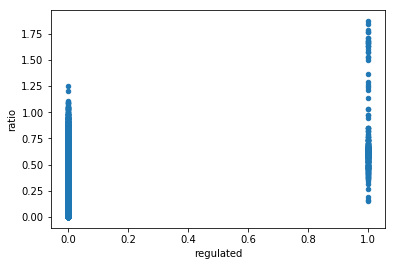

In [47]:
#correlating traffic ratio and regulations
dfwx.plot.scatter(x='regulated', y='ratio')

We can see that there is a sharp decrease in non-regulated airports beyond 100% capacity. But the fact that there are still non-regulated airports despite a high traffic demand reaffirms that the flow manager takes some 'resilience' of the ATM system into account and tries to avoid regulations. The fact that there are regulated airports despite having a very low traffic ratio is more surprising and worth to investigate further.

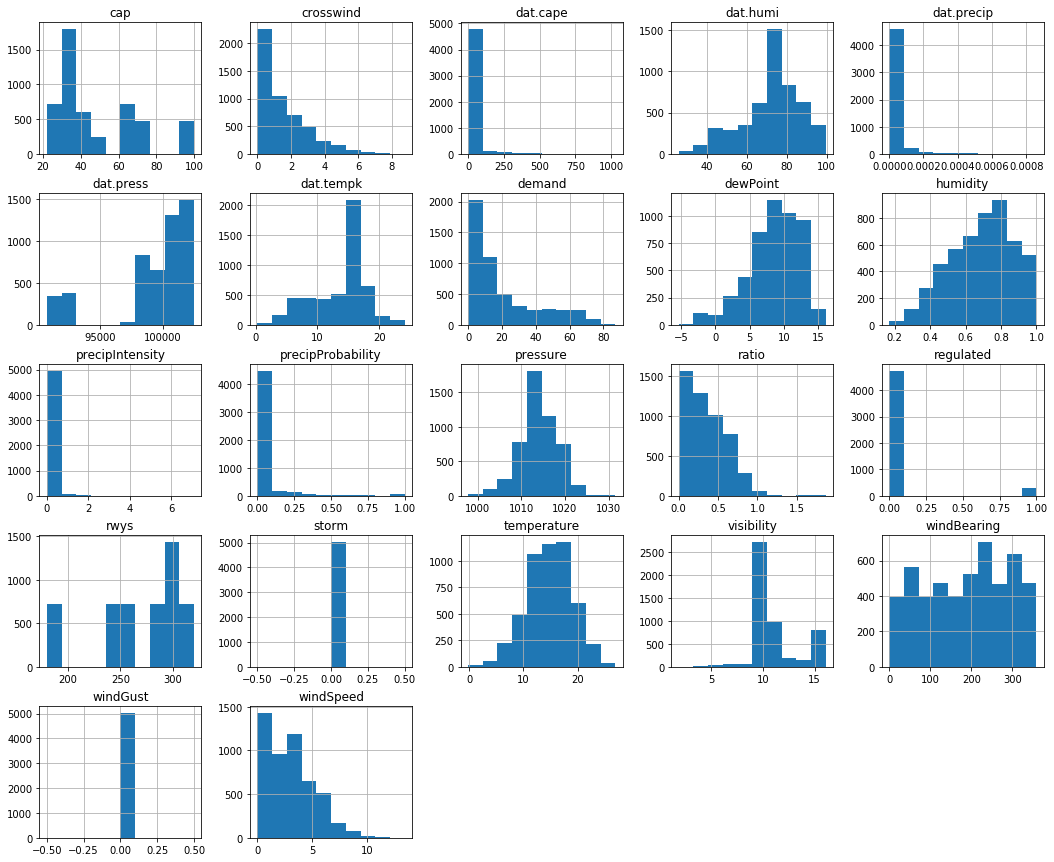

In [50]:
# precipProbability 	storm 	cap 	demand 	ratio 	regulated

mp.rcParams['figure.figsize'] = (18, 15)
dfwx.hist();

From the basic histogram, we can derive several conclusions for the further data processing:
 - there is no strom or windGust event in the dataset, so we can exclude these data points
 - there were only very little days with precipitation in the April 2016 dataset; I decide to leave precipitation in.
 - 'ratio', the column that indicates traffic to demand ratio, shows an interesting distribution insofar that the majority of traffic is in the <0.5 domain, which means that there could be overcapacities for a significant amount of time. 
 - only 6% of the events are "regulated" and will receive a target label of "1". This means that we are dealing with an unbalanced dataset, and special metrics have to be applied for the machine learning part. See paper for more information.
 - Another interestig spike is the visibility distribution with the max at around 10km. This is a hint that perhaps the reported visibility has "standard values", which are not further qualified. This assumption is supported by the fact that in aviation, visibilities of more than 10km are reported as "visibility 10km or more". 
 - While dat.precip and precip coincide, this is not the fact for dat.press and pressure; this data misalignment is surprising and would need further investigation. I decide to use the 'pressure' value, as its distrubution looks more realistic.

## Plotting Feature-Class Relationships

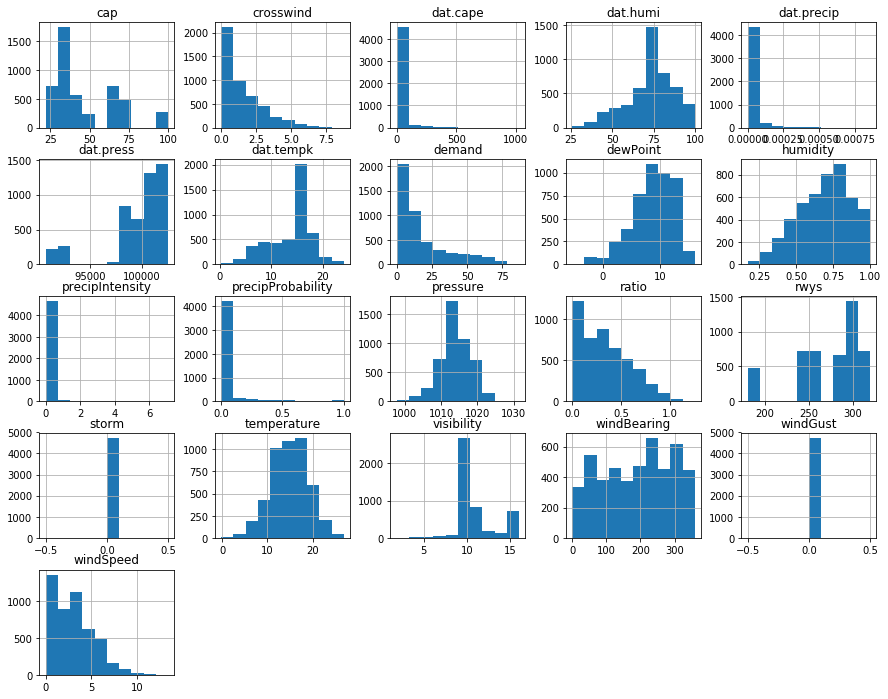

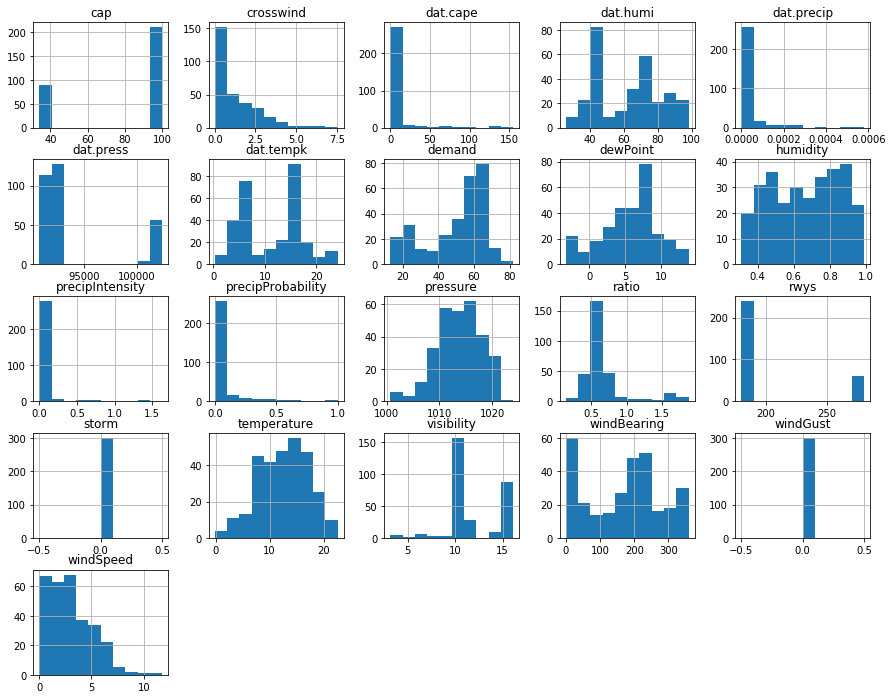

In [60]:
mp.rcParams['figure.figsize'] = (15, 12)
dfwx.groupby('regulated').hist();

Lets compare the distributions of regulations versus traffic demand. In theory and by feedback from CRIDA, a high traffic demand should always lead to more probable regulations. Therefore, the distrubutions of traffic ratio must differ vastly by regulated and non-regulated events. The followin plot supports this assumption:

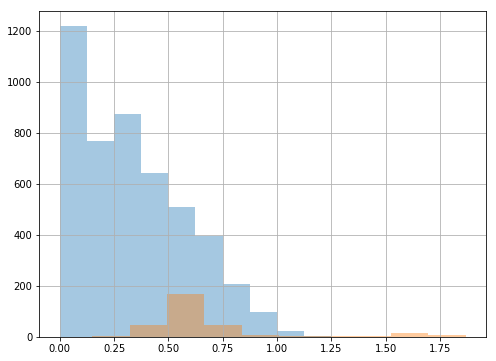

In [65]:
mp.rcParams['figure.figsize'] = (8, 6)
dfwx.groupby('regulated')['ratio'].hist(alpha=0.4);

Finally, we will plot all variables vs. all other variables to get a sense of correlations:

In [68]:
dfwx.columns

Index(['icao', 's', 'iata', 'wkt', 'geojson', 'sta', 'end', 'duration', 'rwys',
       'humidity', 'dewPoint', 'temperature', 'pressure', 'visibility',
       'windBearing', 'windSpeed', 'windGust', 'precipIntensity',
       'precipProbability', 'storm', 'dat.cape', 'dat.tempk', 'dat.press',
       'dat.humi', 'dat.precip', 'crosswind', 'cap', 'demand', 'ratio',
       'regulated'],
      dtype='object')

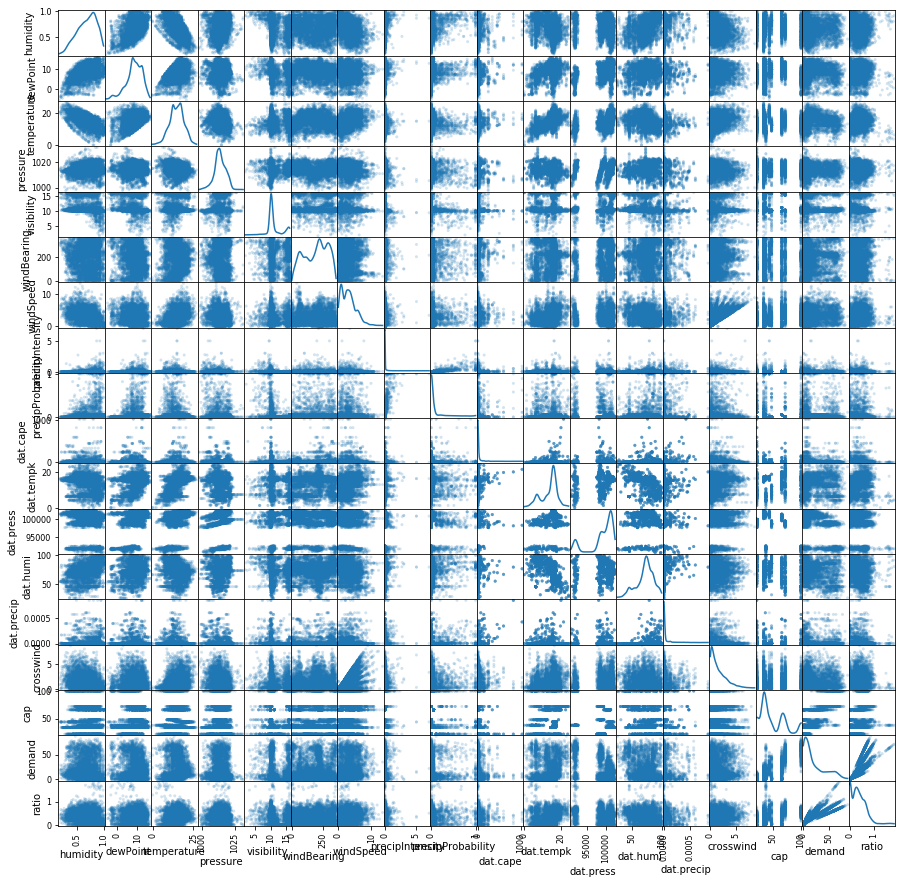

In [81]:
dfplot = dfwx[['humidity', 'dewPoint', 'temperature', 
                'pressure', 'visibility', 'windBearing',
                'windSpeed', 'precipIntensity', 
                'precipProbability', 'dat.cape', 'dat.tempk',
                'dat.press', 'dat.humi', 'dat.precip', 'crosswind', 
                'cap', 'demand', 'ratio']]
pd.plotting.scatter_matrix(dfplot, alpha=0.2, figsize=(15, 15), diagonal='kde');

From the above picture, it is difficult to derive single patterns or correlations that are not obvious (i.e. the linear relation between ratio and demand). Therefore, I conclude that we have the situation that the problem is not reducable to a single or two features.